In [214]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import scipy.stats

In [215]:
df = pd.read_csv('diabetes.csv')
df.shape

(768, 9)

In [216]:
# only first 2 features
X = df.drop(columns = 'Outcome')[ ['Glucose', 'BloodPressure'] ]
y = df['Outcome']

In [217]:
X

,Glucose,BloodPressure
0,148,72
1,85,66
2,183,64
3,89,66
4,137,40
...,...,...
763,101,76
764,122,70
765,121,72
766,126,60


In [218]:
scaler = StandardScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.1, stratify = y, random_state=42)

In [219]:
model = svm.SVC(kernel="linear", probability=True)
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [220]:
acc_score = accuracy_score(model.predict(X_train), y_train)
print(f"Accuracy score for train data is {acc_score}")
acc_score = accuracy_score(model.predict(X_test), y_test)
print(f"Accuracy score for test data is {acc_score}")

Accuracy score for train data is 0.7612156295224313
Accuracy score for test data is 0.6883116883116883


In [221]:
# to numpy array
X = X_train
Y = y_train
classifier = model # or regressor

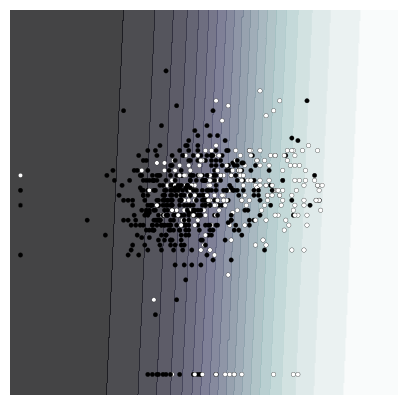

In [242]:
def plot_probability_surface(classifier, levels=20, points=True):
    xx, yy = np.meshgrid(np.linspace(-4, 4, 300), np.linspace(-4,4, 300))
    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    fig, axis = plt.subplots(1, 1, figsize=(5, 5))
    axis.contourf(xx, yy, Z, alpha=0.75, cmap='bone', vmin=0, vmax=1, levels=levels)
    if points:
        axis.scatter(X[:, 0], X[:, 1], c=Y, s=10,
                    cmap='bone', edgecolors='black', linewidth=0.2)
    axis.axis('off')
    return axis
ax = plot_probability_surface(classifier) # cant plot for 8 features atm

In [223]:
def cost_function(x_prime, x, y_prime, lambda_value, model, X):
    mad =  scipy.stats.median_abs_deviation(X, axis=0)
    distance = np.sum(np.abs(x-x_prime)/mad)
    misfit = (model(x_prime, y_prime)-y_prime)**2
    return lambda_value * misfit + distance

In [224]:
def evaluate_model(x, y_prime):
    # round the y_prime value to provide the right class [0,1]
    #predicted_prob = classifier.predict_proba(x.reshape((1, -1)))[0,int(np.round(y_prime))]
    predicted_prob = classifier.predict_proba(x.reshape((1, -1)))[0][0]
    #print(predicted_prob)
    #round_res = classifier.predict_proba(x.reshape((1, -1)))[0,int(np.round(y_prime))]
    #print(f'y_prime: {y_prime}, predicted_prob: {predicted_prob}, round_res: {round_res}')
    return predicted_prob

In [225]:
def get_counterfactuals(x, y_prime_target, model):
    eps = .05 # tolerance
    lambda_min =  1e-10
    lambda_max = 1e5
    lambda_steps = 30
    lambdas = np.logspace(np.log10(lambda_min), 
                            np.log10(lambda_max), 
                            lambda_steps)
    # scan over lambda
    candidates = []
    Y_primes = []
    for lambda_k in lambdas:
        arguments = x, y_prime_target, lambda_k, model, X
        # optimise the cost function -- assuming here it's smooth
        solution = scipy.optimize.minimize(cost_function, 
                                           x, # start from our current observation
                                           args=arguments)
        x_prime_hat = solution.x
        Y_primes.append(model(x_prime_hat, y_prime_target))
        candidates.append(x_prime_hat)
    Y_primes = np.array(Y_primes)
    candidates = np.array(candidates)
    # check if any counterfactual candidates meet the tolerance condition
    eps_condition = np.abs(Y_primes - y_prime_target) <= eps
    # plot y_primes over lambda
    #print(Y_primes)
    # plot y_primes over lambda. use log scale for lambda
    plt.plot(np.log10(lambdas), Y_primes)
    plt.show()
    return candidates[eps_condition]

In [226]:
instance = 0
print(f'instance {instance} has features {X[instance]} and label {Y[instance]}')
print('model prediction: ', classifier.predict(X[instance].reshape(1, -1)))
print('model probability: ', classifier.predict_proba(X[instance].reshape(1, -1)))

instance 0 has features [-0.24707629 -0.26394125] and label 1
model prediction:  [0]
model probability:  [[0.74062089 0.25937911]]


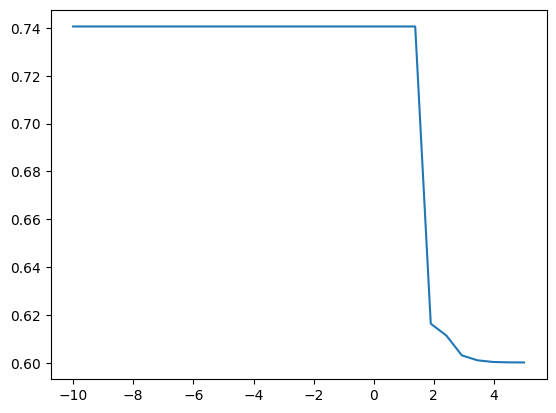

array([[ 0.2242206 , -0.26394125],
       [ 0.24192409, -0.26394125],
       [ 0.27148753, -0.26394125],
       [ 0.27872429, -0.26394125],
       [ 0.28118844, -0.26394125],
       [ 0.28173416, -0.26394125],
       [ 0.28193593, -0.26394125]])

In [227]:
P_prime = 0.6
counterfactuals = get_counterfactuals(X[instance], P_prime, evaluate_model)
counterfactuals

In [228]:
best_counterfactual = counterfactuals[-1]
print("best counterfactual:", best_counterfactual)
print("model prediction on counterfactual:", classifier.predict(best_counterfactual.reshape(1, -1)))
print("Model prediction probs on counterfactual:", classifier.predict_proba(best_counterfactual.reshape(1, -1)))
print("% difference (x', x):", (100*(best_counterfactual-X[instance])/X[instance]).round(2))

best counterfactual: [ 0.28193593 -0.26394125]
model prediction on counterfactual: [0]
Model prediction probs on counterfactual: [[0.60009192 0.39990808]]
% difference (x', x): [-214.11    0.  ]
